In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.contrib import learn
from sklearn.decomposition import PCA

ImportError: No module named 'sklearn.model_selection'

In [2]:
# Read from CSV where every column = [FFT freq bin]
# every row = [epoch 1 (2s): electrode 1, 2, 3, 4] + [epoch 2: electrode 1, 2, 3, 4] + ...
#relax = pd.read_csv("../Muse Data/josh_relax_apr03_night.csv", header=0, index_col=False)
#focus = pd.read_csv("../Muse Data/josh_corvo_task_apr03_night.csv", header=0, index_col=False)

relax = pd.read_csv("../Muse Data/dano_watchingtv_apr02.csv", header=0, index_col=False)
focus = pd.read_csv("../Muse Data/danofocus_apr02.csv", header=0, index_col=False)

# Chop off irrelevant frequencies
relax = relax.iloc[:,1:54]
relax = relax.drop('Channel', axis=1)
focus = focus.iloc[:,1:54]
focus = focus.drop('Channel', axis=1)

# Add labels
relax['label'] = 0
focus['label'] = 1   

In [218]:
# Combine focus and relax dataframes into a numeric values and complementary labels dataframe
# rows = [relax data] + [focus data]

values = pd.concat([relax.iloc[:,0:53], focus.iloc[:,0:53]]).reset_index(drop=True)
labels = pd.concat([pd.DataFrame(relax['label']), pd.DataFrame(focus['label'])]).reset_index(drop=True)

# Convert labels from a dataframe to a 1D matrix
#c, r = labels.shape
#labels = labels.as_matrix().reshape(c,)

# Split values and labels arrays into random train and test subsets (20% set aside for testing)
X_train, X_test, y_train, y_test = train_test_split(values,labels,test_size=0.2)
X_train = X_train.as_matrix()

# Convert labels from a dataframe to a 1D matrix
c, r = y_train.shape
y_train = y_train.as_matrix().reshape(c,)

d, s = y_test.shape
y_test = y_test.as_matrix().reshape(d,)



Step #100
Loss = [ 3.54348564]
Step #200
Loss = [ 2.58038688]
Step #300
Loss = [ 2.48771977]
Step #400
Loss = [ 2.38350558]
Step #500
Loss = [ 2.40933394]
Step #600
Loss = [ 2.35728502]
Step #700
Loss = [ 2.31530404]
Step #800
Loss = [ 2.28674912]
Step #900
Loss = [ 2.28619599]
Step #1000
Loss = [ 2.29733944]


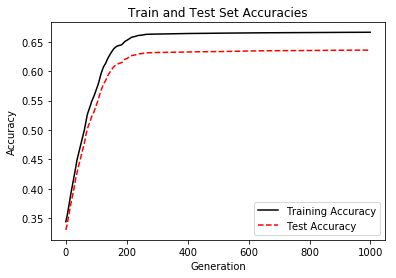

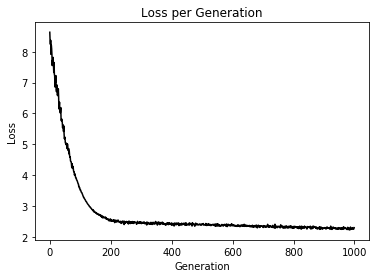

In [220]:
# Create graph
sess = tf.Session()

# Declare batch size, get some sizes to use
batch_size = len(X_train)
x_length, x_width = X_train.shape
y_length = len(y_train)

# Initialize placeholders
x_data = tf.placeholder(shape=[None, x_width], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[x_width, x_length]))
b = tf.Variable(tf.random_normal(shape=[1, y_length]))

# Declare model operations
model_output = tf.subtract(tf.matmul(x_data, A), b)

# Declare vector L2 'norm' function squared
l2_norm = tf.reduce_sum(tf.square(A))

# Declare loss function
# Loss = max(0, 1-pred*actual) + alpha * L2_norm(A)^2
# L2 regularization parameter, alpha
alpha = tf.constant([0.01])
# Margin term in loss
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_target))))
# Put terms together
loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

# Declare prediction function
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

# Declare optimizer
my_opt = tf.train.AdagradOptimizer(0.1)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
train_accuracy = []
test_accuracy = []
for i in range(1000):
    rand_index = np.random.choice(len(X_train), size=batch_size)
    rand_x = X_train[rand_index]
    rand_y = np.transpose([y_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    train_acc_temp = sess.run(accuracy, feed_dict={x_data: X_train, y_target: np.transpose([y_train])})
    train_accuracy.append(train_acc_temp)
    
    test_acc_temp = sess.run(accuracy, feed_dict={x_data: X_test, y_target: np.transpose([y_test])})
    test_accuracy.append(test_acc_temp)
    
    if (i+1)%100==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))


# Plot train/test accuracies
plt.plot(train_accuracy, 'k-', label='Training Accuracy')
plt.plot(test_accuracy, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()